<a href="https://www.kaggle.com/code/gustavolenin/preco-de-combustiveis-2004-a-2020?scriptVersionId=105172253" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Definição do Problema

### Análise Exploratória - Preços de Combustíveis

Em cumprimento às determinações da Lei do Petróleo (Lei nº 9478/1997, artigo 8º), a ANP acompanha os preços praticados por revendedores de combustíveis automotivos e de gás liquefeito de petróleo envasilhado em botijões de 13 quilos (GLP P13), por meio de uma pesquisa semanal de preços realizada por empresa contratada.

Neste projeto será realizada uma análise exploratória dos dados.

# 2. Extração dos Dados

#### Importação de Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from category_encoders import TargetEncoder

#### Extração dos Dados

In [2]:
# Exibição das 5 Primeiras Linhas do DataFrame
df = pd.read_csv('../input/preo-combustveis-brasil/microdados.csv')
df.head()

,ano,sigla_uf,id_municipio,bairro_revenda,cep_revenda,endereco_revenda,cnpj_revenda,nome_estabelecimento,bandeira_revenda,data_coleta,produto,unidade_medida,preco_compra,preco_venda
0,2004,MG,3170701,CENTRO,37002-040,"PRACA MARECHAL FLORIANO,100",86.437.472/0001-21,SANTA LUIZA DERIVADOS DE PETROLEO LTDA,BRANCA,2004-05-10,etanol,R$/litro,0.9367,1.280
1,2004,SP,3554102,VILA SAO JOSE,12070-590,"AVENIDA DOM DUARTE LEOPOLDO E SILVA,501",03.842.497/0001-83,AUTO POSTO ANA ROSA TAUBATE LTDA - EPP,ALE COMBUSTÍVEIS,2004-05-10,gasolina,R$/litro,1.7020,1.899
2,2004,SP,3554102,PARQUE SAO LUIS,12061-600,"RUA PADRE FISCHER,1487",01.583.271/0001-80,ABOU HALA & IBANHES AUTO POSTO LTDA.,BRANCA,2004-05-10,diesel,R$/litro,NaN,1.399
3,2004,SP,3554102,PARQUE SAO LUIS,12061-600,"RUA PADRE FISCHER,1487",01.583.271/0001-80,ABOU HALA & IBANHES AUTO POSTO LTDA.,BRANCA,2004-05-10,etanol,R$/litro,0.5878,0.799
4,2004,SP,3554102,PARQUE SAO LUIS,12061-600,"RUA PADRE FISCHER,1487",01.583.271/0001-80,ABOU HALA & IBANHES AUTO POSTO LTDA.,BRANCA,2004-05-10,gasolina,R$/litro,1.6218,1.899


#### Descrição de cada coluna

`ano` - Ano

`sigla_uf` - Sigla da Unidade Federativa da revenda pesquisada

`id_municipio` - ID Município IBGE - 7 Dígitos

`bairro_revenda` - Nome do bairro da revenda pesquisada

`cep_revenda` - Número do Código do Endereço Postal (CEP) do logradouro da revenda pesquisada

`cnpj_revenda` - Número do Cadastro Nacional de Pessoa Jurídica da revenda

`nome_estabelecimento` - Nome do estabelecimento

`bandeira_revenda` - Nome da Bandeira da revenda

`data_coleta` - Data da coleta do(s) preço(s)

`produto` - Nome do combustível

`unidade_medida` - Unidade de Medida

`preco_compra` - Preço de venda da distribuidora para o posto revendedor de combustível

`preco_venda` - Preço de venda ao consumidor final praticado pelo revendedor na data da coleta


# 3. Preparação dos Dados

In [3]:
# Nomes das colunas
df.columns

Index(['ano', 'sigla_uf', 'id_municipio', 'bairro_revenda', 'cep_revenda',
       'endereco_revenda', 'cnpj_revenda', 'nome_estabelecimento',
       'bandeira_revenda', 'data_coleta', 'produto', 'unidade_medida',
       'preco_compra', 'preco_venda'],
      dtype='object')

In [4]:
# Verificando a existência de possíveis linhas duplicadas
df.duplicated().sum()

0

In [5]:
# Dropando a coluna de Id do município
df.drop(['id_municipio','cnpj_revenda','cep_revenda','endereco_revenda','data_coleta','nome_estabelecimento'],axis=1,inplace=True)

In [6]:
# Dimensão do Dataset
print('Número de Linhas = ',df.shape[0])
print('Número de Colunas = ',df.shape[1])

Número de Linhas =  26514824
Número de Colunas =  8


In [7]:
# Tipo de Cada Coluna
df.dtypes

ano                   int64
sigla_uf             object
bairro_revenda       object
bandeira_revenda     object
produto              object
unidade_medida       object
preco_compra        float64
preco_venda         float64
dtype: object

In [8]:
unique_values = []
# Verificando os valores únicos por coluna
[(unique_values.append(str(df[coluna].nunique())),print(coluna+' possui '+str(df[coluna].nunique())+' valores únicos')) for coluna in df.columns];

ano possui 18 valores únicos
sigla_uf possui 27 valores únicos
bairro_revenda possui 19689 valores únicos
bandeira_revenda possui 268 valores únicos
produto possui 9 valores únicos
unidade_medida possui 3 valores únicos
preco_compra possui 106753 valores únicos
preco_venda possui 8048 valores únicos


In [9]:
# Excluindo a lista unique_values
del unique_values
gc.collect();

In [10]:
# Verificando a existência de possíveis valores ausentes
df.isnull().sum()

ano                        0
sigla_uf                   0
bairro_revenda         69362
bandeira_revenda           1
produto                    0
unidade_medida             1
preco_compra        14419107
preco_venda                1
dtype: int64

Notamos que há valores ausentes, neste problema descartarei estes valores

In [11]:
df.dropna(inplace=True)

# 4. Exploração / Visualização dos Dados

#### Estatística Descritiva

In [12]:
# Estatística Descritiva

# O comando describe retorna parâmetros estatísticos tais como: contagem de linhas, média, desvio 
# padrão, mínimo, máximo, primeiro, segundo e terceiro quartis.
# Deve-se lembrar que este comando só se aplica às variáveis numéricas.

df_describe = df.describe().T

Embora bastante útil, o comando describe não expressa alguns parâmetros estatísticos relevantes para a análise de dados, tais como: skewness, kurtosis.

df.skew() retorna um valor que nos indica como está a distribuição dos dados para aquela váriavel ou seja, se os dados estão simétricos ou assimétricos, caso estejam assimétricos podemos saber se está para esquerda ou para a direita. Se a assimetria (skew) estiver entre -0,5 e 0,5, os dados são bastante simétricos; Se a assimetria (skew) estiver entre -1 e -0,5 ou entre 0,5 e 1, os dados serão moderadamente distorcidos; Se a assimetria (skew) for menor que -1 ou maior que 1, os dados são altamente distorcidos;

Kurtosis é uma medida que caracteriza o achatamento da curva da função de distribuição de probabilidade, de tal forma que para uma distribuição normal, o valor de Kurtosis é 3. Frequentemente utiliza-se como parâmetro o excesso de kurtosis, obtido apenas realizando a subtração do valor de kurtosis por 3.

Se o excesso de kurtosis for igual a 0 significa dizer que se trata de uma distribuição normal;

Se o excesso de kurtosis for maior do que 0 significa dizer que a distribuição é mais concentrada do que a distribuição normal;

Se o excesso de kurtosis for menor do que 0 significa dizer que a distribuição é menos concentrada do que a distribuição normal;

O comando df.kurtosis() retorna o excesso de kurtosis;

A mediana separa a amostra em duas partes de modo que ela se encontra no centro da amostra. Para obtê-la deve-se ordenar a amostra em ordem crescente ou decrescente e buscar pelo valor que se localiza no centro da amostra.

O comando df.median() retorna a mediana de cada variável pertencente ao DataFrame df.

O intervalo representa a distância entre os dois extremos em uma amostra, ou seja, valor máximo subtraído pelo valor mínimo.

In [13]:
# Definindo as variáveis numéricas e categóricas
num_attributes = df.select_dtypes(include=['int64', 'float64'])
cat_attributes = df.select_dtypes(exclude=['int64', 'float64'])

In [14]:
df_skewness  = pd.DataFrame(num_attributes.skew(),columns=['skew'])
df_kurtosis  = pd.DataFrame(num_attributes.kurtosis(),columns=['kurtosis'])
df_median    = pd.DataFrame(num_attributes.median(),columns=['median'])
df_intervalo = pd.DataFrame(num_attributes.max() - num_attributes.min(),columns=['range'])

In [15]:
df_descritive_statistics = pd.concat([df_describe,df_skewness,df_kurtosis,df_median,df_intervalo],axis=1)
df_descritive_statistics

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,median,range
ano,12060097.0,2010.234978,4.546526,2004.0000,2006.0000,2009.0000,2014.0000,2020.00,0.449198,-0.934964,2009.0000,16.0000
preco_compra,12060097.0,6.259457,11.036330,0.3257,1.6817,2.1364,2.7347,94.50,2.606155,6.292515,2.1364,94.1743
preco_venda,12060097.0,7.935375,14.623714,0.5900,1.8990,2.4690,3.1500,115.99,2.614433,6.212471,2.4690,115.4000


In [16]:
# Deletando o dataframe df_descritive_statistics pois não utilizaremos mais futuramente
del df_descritive_statistics, df_skewness, df_kurtosis, df_median, df_intervalo, df_describe
gc.collect();

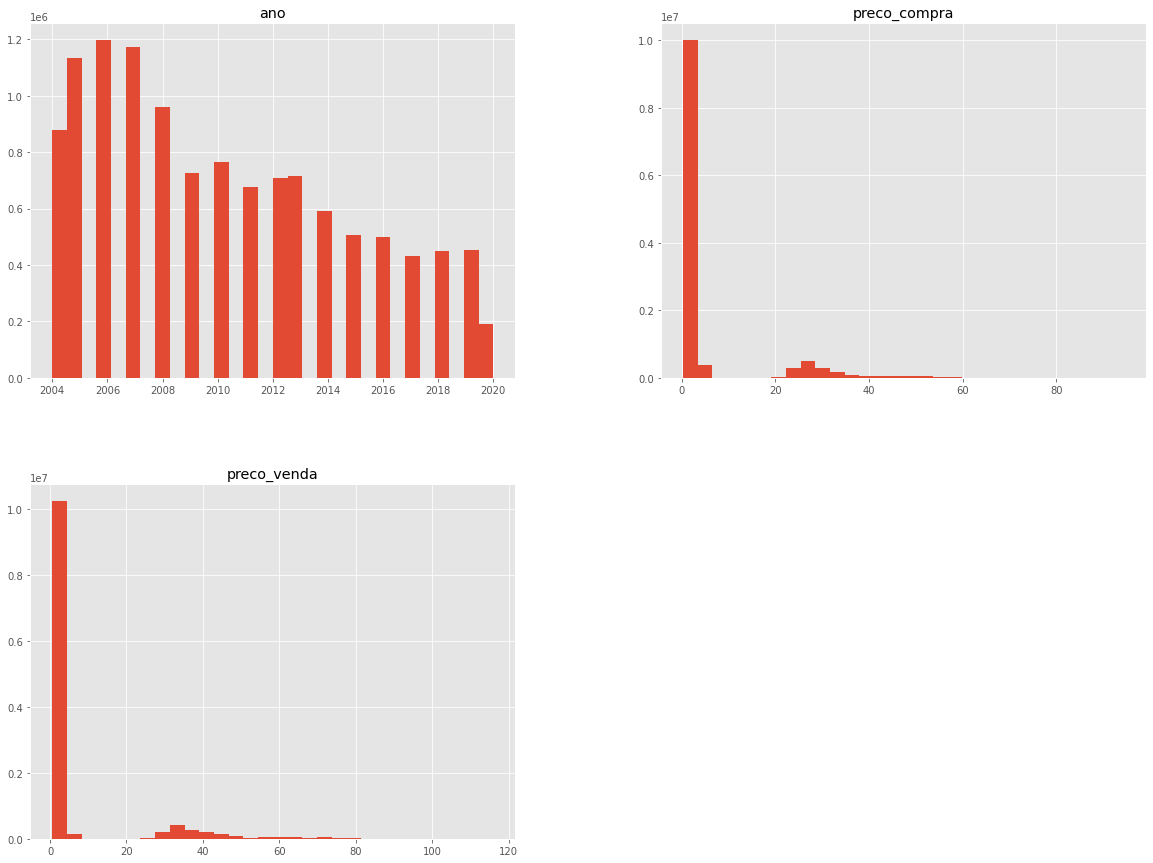

In [17]:
# Plotagem de histogramas 
# Histogramas expressam a distribuição de frequência para variáveis numéricas

df.hist(bins=30,figsize=(20,15));

Podemos identificar que houve uma maior demanda por produtos de valores inferiores.

## Revenda por tipo de produto

In [18]:
# Verificando quais são os tipos de produtos, em ordem alfabética, avaliados neste dataset
produtos = sorted(df.produto.unique())
produtos

['diesel', 'diesel s10', 'diesel s50', 'etanol', 'gasolina', 'glp', 'gnv']

In [19]:
# Verificar a quantidade de anos que os dados de cada tipo de produto abrangem 
print('dielsel: ',df.ano[df.produto == 'diesel'].nunique())
print('dielsel s10: ',df.ano[df.produto == 'diesel s10'].nunique())
print('dielsel s50: ',df.ano[df.produto == 'diesel s50'].nunique())
print('etanol: ',df.ano[df.produto == 'etanol'].nunique())
print('gasolina: ',df.ano[df.produto == 'gasolina'].nunique())
print('glp: ',df.ano[df.produto == 'glp'].nunique())
print('gnv: ',df.ano[df.produto == 'gnv'].nunique())

dielsel:  17
dielsel s10:  9
dielsel s50:  1
etanol:  17
gasolina:  17
glp:  17
gnv:  17


Em virtude de haver apenas dados referentes a um ano no dataframe diesel_s50, este será excluído da análise

In [20]:
df = df[df.produto != 'diesel s50']

In [21]:
# Cálculo do preço médio de compra e de venda por tipo de produto
df_preco_compra = df.groupby('produto').preco_compra.mean().sort_values().reset_index()
df_preco_venda  = df.groupby('produto').preco_venda.mean().sort_values().reset_index()

# Identificando a unidade de medida de cada um dos tipos de produto
df_unidade_medida = df.groupby('produto').unidade_medida.unique().reset_index()

# Agrupando os DataFrames
df_produto = df_preco_compra.merge(df_preco_venda,on='produto').merge(df_unidade_medida,on='produto')

# Criando nova coluna com a diferença entre os preços
df_produto['lucro'] = df_produto.preco_venda - df_produto.preco_compra

# Criando nova coluna com a margem de lucro
df_produto['margem_lucro'] = 100*df_produto.lucro/df_produto.preco_venda

# Visualizar o DataFrame
df_produto

,produto,preco_compra,preco_venda,unidade_medida,lucro,margem_lucro
0,gnv,1.125563,1.614753,[R$/m3],0.489191,30.295065
1,etanol,1.627610,1.924001,[R$/litro],0.296391,15.404928
2,diesel,1.875067,2.110942,[R$/litro],0.235875,11.173913
3,gasolina,2.440622,2.823537,[R$/litro],0.382915,13.561524
4,diesel s10,2.800803,3.183383,[R$/litro],0.382580,12.018047
5,glp,32.210910,42.246120,[R$/13kg],10.035210,23.754158


Podemos observar que na revenda destes produtos, aquele que fornece o maior percentual de lucro em média ao longo destes anos foi o gnv, seguido pelo glp.

In [22]:
# Deletando o dataframe df_descritive_statistics pois não utilizaremos mais futuramente
del df_produto, df_unidade_medida
gc.collect();

## Revenda por tipo de produto e por ano

In [23]:
# Cálculo do preço médio de compra e de venda por tipo de produto
df_preco_compra = df.groupby(['produto','ano']).preco_compra.mean().reset_index().sort_values(by=['produto','ano'])
df_preco_venda  = df.groupby(['produto','ano']).preco_venda.mean().reset_index().sort_values(by=['produto','ano']).drop(['ano','produto'],axis=1)

# Agrupando os DataFrames
df_produto_ano = pd.concat([df_preco_compra,df_preco_venda],axis=1)

# Criando nova coluna com a diferença entre os preços
df_produto_ano['lucro'] = df_produto_ano.preco_venda - df_produto_ano.preco_compra

# Criando nova coluna com a margem de lucro
df_produto_ano['margem_lucro'] = 100*df_produto_ano.lucro/df_produto_ano.preco_venda

# Visualizar o DataFrame
df_produto_ano

,produto,ano,preco_compra,preco_venda,lucro,margem_lucro
0,diesel,2004,1.338026,1.516628,0.178602,11.776274
1,diesel,2005,1.549685,1.737849,0.188164,10.827404
2,diesel,2006,1.691188,1.884697,0.193509,10.267379
3,diesel,2007,1.691489,1.876851,0.185361,9.876196
4,diesel,2008,1.841343,2.037682,0.196339,9.635409
...,...,...,...,...,...,...
89,gnv,2016,1.591210,2.293314,0.702104,30.615241
90,gnv,2017,1.673769,2.400115,0.726346,30.262971
91,gnv,2018,1.949797,2.804422,0.854625,30.474189
92,gnv,2019,2.386468,3.277294,0.890826,27.181752


In [24]:
# DataFrames para cada tipo de produto
diesel = df_produto_ano[df_produto_ano.produto == 'diesel']
diesel_s10 = df_produto_ano[df_produto_ano.produto == 'diesel s10']
etanol = df_produto_ano[df_produto_ano.produto == 'etanol']
gasolina = df_produto_ano[df_produto_ano.produto == 'gasolina']
glp = df_produto_ano[df_produto_ano.produto == 'glp']
gnv = df_produto_ano[df_produto_ano.produto == 'gnv']

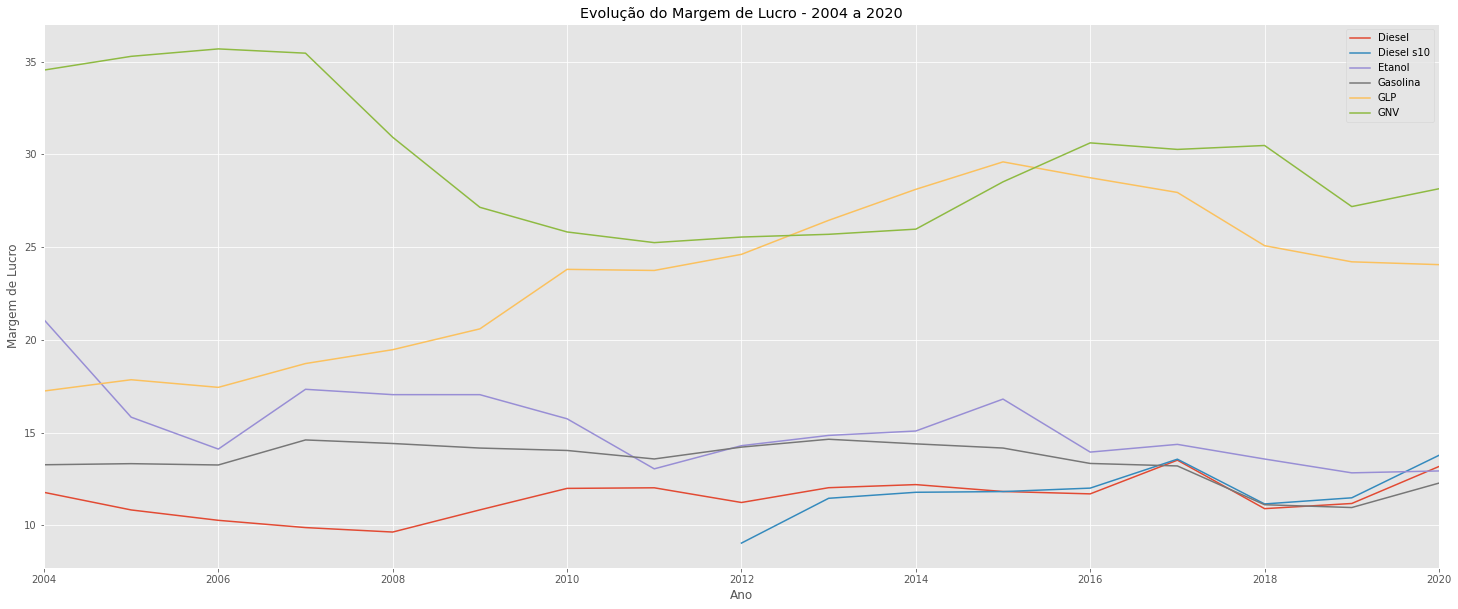

In [25]:
# Plotagem dos gráficos
plt.figure(figsize=(25,10))
sns.lineplot(data=diesel,x='ano',y='margem_lucro',label='Diesel');
sns.lineplot(data=diesel_s10,x='ano',y='margem_lucro',label='Diesel s10');
sns.lineplot(data=etanol,x='ano',y='margem_lucro',label='Etanol');
sns.lineplot(data=gasolina,x='ano',y='margem_lucro',label='Gasolina');
sns.lineplot(data=glp,x='ano',y='margem_lucro',label='GLP');
sns.lineplot(data=gnv,x='ano',y='margem_lucro',label='GNV');
plt.xlabel('Ano')
plt.ylabel('Margem de Lucro')
plt.title('Evolução do Margem de Lucro - 2004 a 2020')
plt.xlim([2004,2020])
plt.legend();

In [26]:
# Deletando dataframes que não utilizaremos mais futuramente
del diesel, diesel_s10, etanol, gasolina, glp, gnv
gc.collect();

Nota-se que as informações a respeito do Diesel s10 só estão disponíveis a partir de 2012. Isso provavelmente se deve ao fato de que o diesel com baixo teor de enxofre, o S10 se tornou obrigatório para o transporte rodoviário a partir do ano de 2012, justamente por conter menos enxofre e ser menos poluente. 

No ano de 2004, o GNV e o etanol tiveram o maior percentual de lucro e a partir deste ano, o etanol deu lugar ao GLP como segundo maior percentual de lucro até 2020.

Vale mencionar que de 2004 a 2016, o percentual de lucro com a venda de gasolina era bem maior do que o gerado pelo diesel. No ano de 2017, houve a inversão disto e esse padrão se manteve até o ano de 2020.

Outro ponto bastante interessante é o fato de que o diesel s10, menos poluente que o diesel comum e o diesel s50, levou 3 anos (desde a obrigatoriedade para o uso no transporte rodoviário) para atingir o percentual de lucro dos demais tipos de diesel e, no ano seguinte, se tornou mais lucrativo que os outros, padrão que se manteve até 2020.

Percebe-se que de 2004 a 2020, houve: uma considerável redução da margem de lucro para o GNV e etanol, a margem referente à gasolina sofreu uma pequena redução, enquanto a margem relacionada ao diesel sofreu um leve aumento. O diesel s10, por sua vez, teve um aumento considerável na sua margem de lucro.

## Distribuição de Preço de Compra e Preço de Venda por Estado

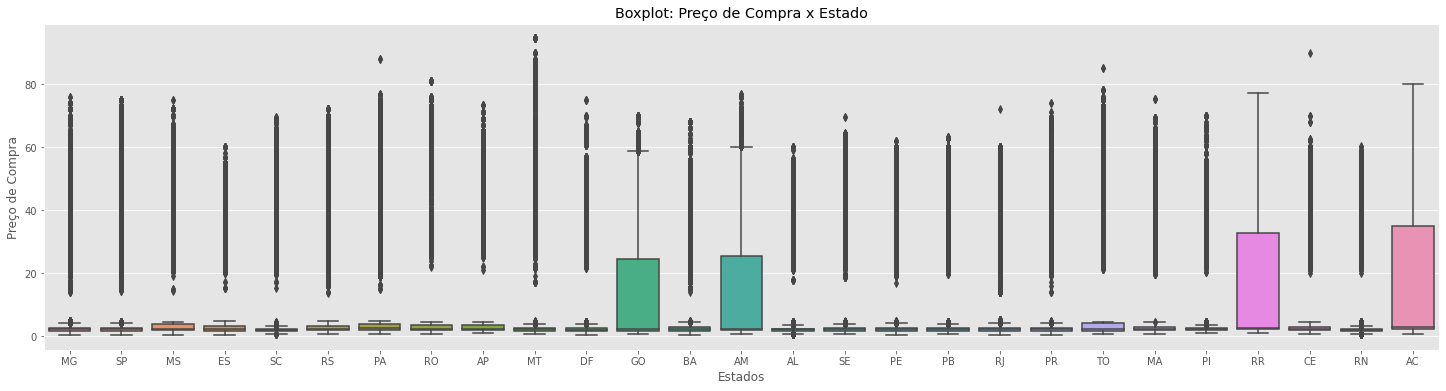

In [27]:
# Afim de visualizar a distribuição dos dados para cada variável e identificar possíveis outliers
plt.figure(figsize=(25,6))
sns.boxplot(data=df,y='preco_compra',x='sigla_uf')
plt.xlabel('Estados')
plt.ylabel('Preço de Compra')
plt.title('Boxplot: Preço de Compra x Estado');

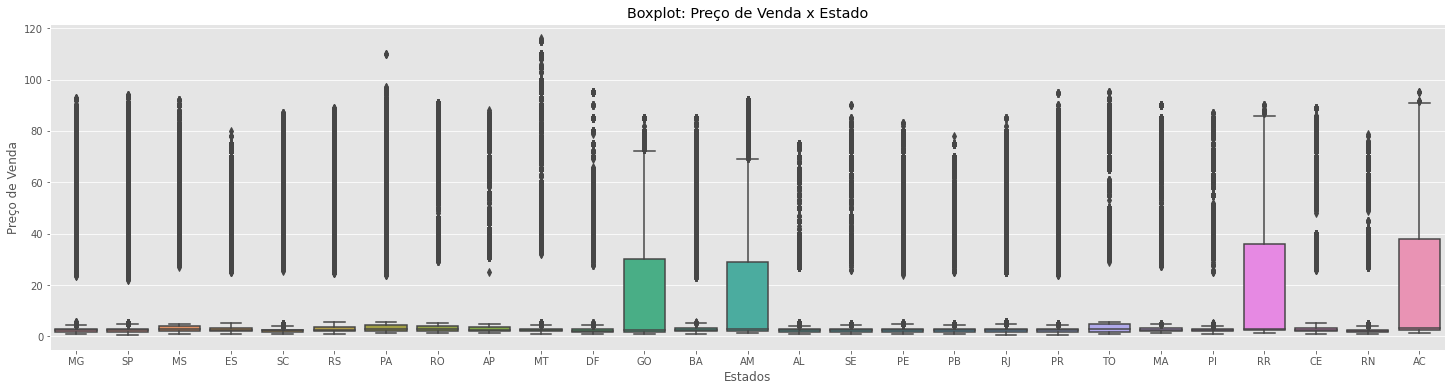

In [28]:
plt.figure(figsize=(25,6))
sns.boxplot(data=df,y='preco_venda',x='sigla_uf')
plt.xlabel('Estados')
plt.ylabel('Preço de Venda')
plt.title('Boxplot: Preço de Venda x Estado');

Através do boxplot, identificamos diversos outliers. Além disso, nota-se que as distribuições de preço de compra e preço de venda para os estados: Acre, Roraima, Amazonas e Goiás, são bem menos concentradas do que as demais distribuições referentes aos outros estados. Isso, indica uma grande volatilidade nos dados para estes estados. Outro ponto relevante é que destes 4 estados, 3 deles pertencem à região norte.

## Margem de Lucro por Estado

In [29]:
df_precos_estados = df.groupby(['sigla_uf','produto']).agg({'preco_compra':'mean','preco_venda':'mean'}).reset_index()

# Criando nova coluna com a diferença entre os preços
df_precos_estados['lucro'] = df_precos_estados.preco_venda - df_precos_estados.preco_compra

# Criando nova coluna com a margem de lucro
df_precos_estados['margem_lucro'] = 100*df_precos_estados.lucro/df_precos_estados.preco_venda

df_precos_estados_diesel = df_precos_estados[df_precos_estados.produto == 'diesel'][['sigla_uf','margem_lucro']].sort_values(by='margem_lucro',ascending=False)

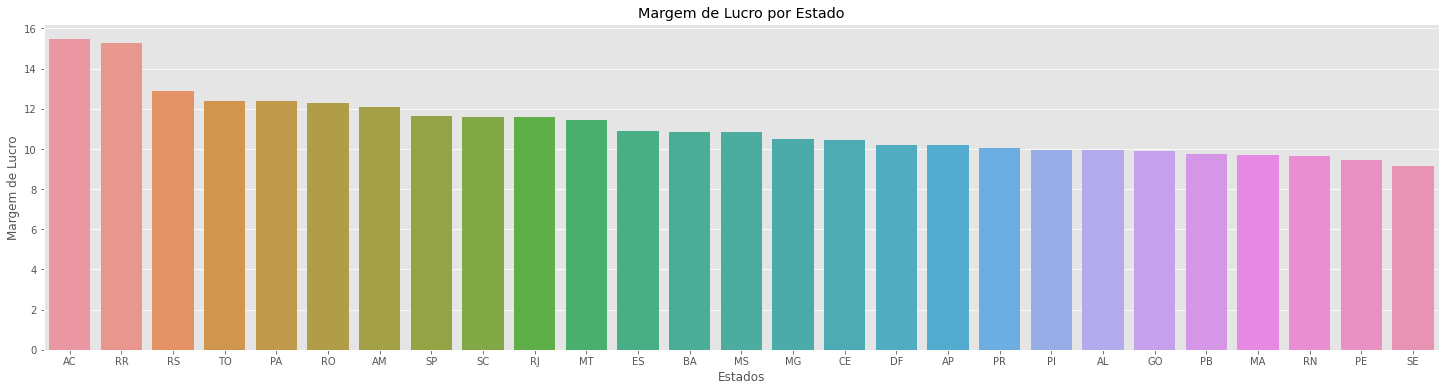

In [30]:
plt.figure(figsize=(25,6))
plt.title('Margem de Lucro por Estado');
sns.barplot(data=df_precos_estados_diesel,x='sigla_uf',y='margem_lucro')
plt.xlabel('Estados')
plt.ylabel('Margem de Lucro');

Nota-se que as maiores margens de lucro foram para os estados: Acre, Roraima, Rio Grande do Sul, Tocantins, Pará, Rondônia, Amazonas, São Paulo, Santa Catarina e Rio de Janeiro. Percebe-se que com exceção do estado de Goiás, os demais estados que apresentaram grande volatilidade dos preços de compra e de venda estiveram entre os estados com maior margem de lucro no país, a exemplo de: Acre, Roraima e Amazonas. 

In [31]:
# Deletando dataframes que não utilizaremos mais futuramente
del df_precos_estados, df_precos_estados_diesel
gc.collect();

## 10 Estados com maior Preço de Compra

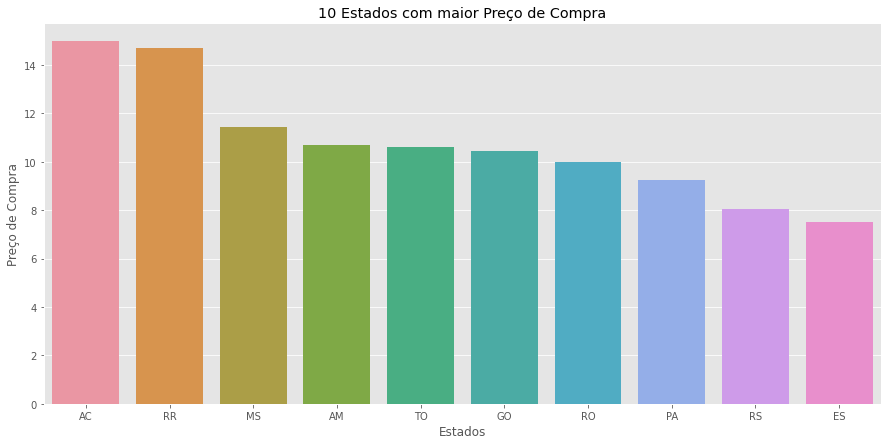

In [32]:
plt.figure(figsize=(15,7))
df_preco_compra_top10 = df.groupby('sigla_uf').preco_compra.mean().reset_index().sort_values(by='preco_compra',ascending=False)[:10]
sns.barplot(data=df_preco_compra_top10,x='sigla_uf',y='preco_compra').set_title('10 Estados com maior Preço de Compra')
plt.xlabel('Estados')
plt.ylabel('Preço de Compra');

Nota-se que os estados: Acre, Roraima e Amazonas pertencentes aos estados com maiores margens de lucro também estão entre os estados com maior preço de compra. O preço de compra dos combustíveis pelas revendedoras é influenciado por fatores como: custo de produção da Petrobras nas refinarias, impostos federais e estaduais (ICMS, PIS/Pasep e Cofins, e Cide) e custo do etanol anidro obrigatório. Dessa forma, pode-se observar que os impostos estaduais impactam consideravelmente no preço de compra.

In [33]:
del df_preco_compra_top10
gc.collect();

## 10 Estados com maior Preço de Venda

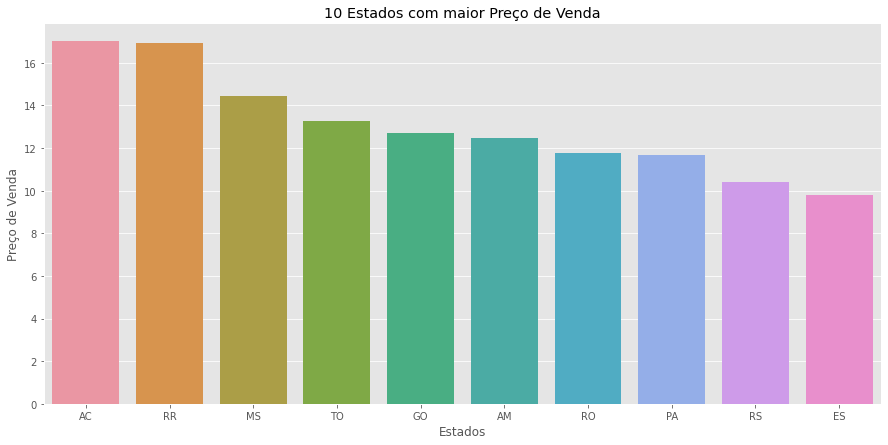

In [34]:
plt.figure(figsize=(15,7))
df_preco_venda_top10 = df.groupby('sigla_uf').preco_venda.mean().reset_index().sort_values(by='preco_venda',ascending=False)[:10]
sns.barplot(data=df_preco_venda_top10,x='sigla_uf',y='preco_venda').set_title('10 Estados com maior Preço de Venda')
plt.xlabel('Estados')
plt.ylabel('Preço de Venda');

Nota-se que os estados: Acre, Roraima e Amazonas pertencentes aos estados com maiores margens de lucro e estão entre os estados com maior preço de compra também estão entre os estados com maior preço de venda. Indicando, dessa forma, uma possível relação entre estas duas variáveis, o que faz todo sentido uma vez que para manter a rentabilidade das revendedoras se torna necessário aumentar o preço de venda quando ocorre aumento no preço de compra. 

In [35]:
del df_preco_venda_top10
gc.collect();

### Análise Bivariada

O comando .pairplot gera distribuições univariadas na diagonal e distribuições bivariadas fora das diagonais

A importância desse tipo de gráfico é observar o comportamento das variáveis através de histogramas na diagonal e scatterplots fora da diagonal. Esses scatterplots representam a relação entre os pares de features.

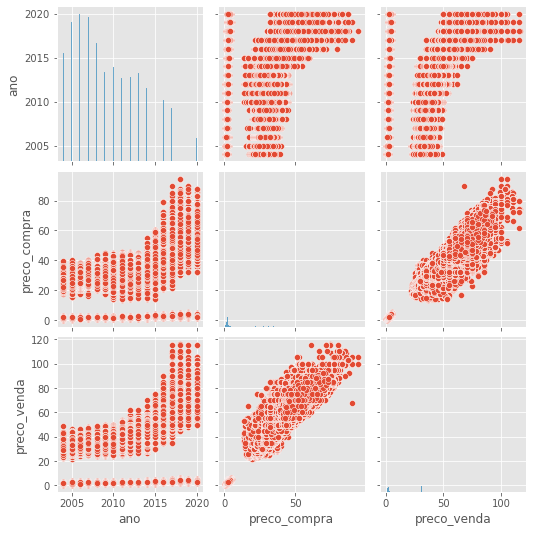

In [36]:
sns.pairplot(df)
plt.show()

In [37]:
# Aplicando coeficiente de correlação de Pearson
df_corr = df.corr()

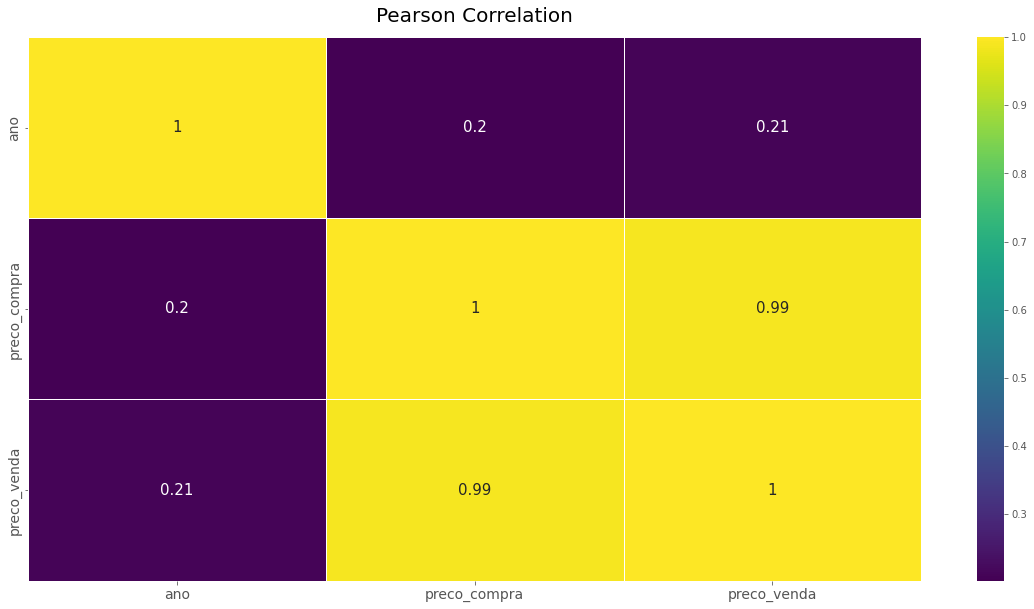

In [38]:
# Visualizar a correlação entre cada variável utilizando a correlação de Pearson 
_ = plt.figure(figsize = (20,10))
res = sns.heatmap(df_corr, vmax = 1, linewidths = 0.9, cmap = 'viridis',annot_kws={"size": 15},annot=True)
_ = plt.title('Pearson Correlation', fontsize = 20, pad = 15)
_ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14)
_ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14)

O coeficiente de correlação de Pearson nos auxiliar a identificar a intensidade e a direção da relação linear entre duas variáveis. Neste caso, nota-se que a correlação entre as variáveis: preço de compra e preço de venda realmente é significantemente alta, indicando que um aumento no preço de compra é acompanhado por um aumento no preço de venda.

In [39]:
# Economizando RAM
del df_corr, res
gc.collect();

# 5. Modelo de Machine Learning - Regressão Linear / Ridge / Lasso

### Remoção de Outliers

In [40]:
# Cálculo do primeiro quartil (Q1)
Q1 = np.percentile(df['preco_venda'], 25,
                   interpolation = 'midpoint')

# Cálculo do terceiro quartil (Q3) 
Q3 = np.percentile(df['preco_venda'], 75,
                   interpolation = 'midpoint')

# Cálculo do IQR (Intervalo Interquartil)
IQR = Q3 - Q1

# Cálculo do limite superior
upper = Q3 +1.5*IQR

# Cálculo do limite inferior
lower = Q1 - 1.5*IQR
 
# Removendo outliers
df = df[df.preco_venda <= upper]
df = df[df.preco_venda >= lower]

df_sem_outliers = df.copy()
df_sem_outliers.drop('unidade_medida',axis=1,inplace=True)

In [41]:
# Economizando RAM
del df
gc.collect();

### Target encoding

In [42]:
# Realizando split dos dados
df_target_encoding = df_sem_outliers.copy()
X = df_target_encoding.drop('preco_venda',axis=1)
y = df_target_encoding.preco_venda
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.30,random_state=0)

In [43]:
# Concatenando os dados de treino para aplicar o encoding em seguida
df_target_encoding_train = pd.concat([Xtrain,ytrain],axis=1)
# Concatenando os dados de treino para aplicar o encoding em seguida
df_target_encoding_test = pd.concat([Xtest,ytest],axis=1)

In [44]:
# Aplicação do encoding nos dados de treino
from category_encoders import TargetEncoder
encoder = TargetEncoder();
df_target_encoding_train=encoder.fit_transform(df_target_encoding_train,df_target_encoding_train.preco_venda);
# Aplicação do encoding nos dados de teste
df_target_encoding_test=encoder.transform(df_target_encoding_test,df_target_encoding_test.preco_venda);

In [45]:
# Separando o Xtrain do ytrain
Xtrain = df_target_encoding_train.drop('preco_venda',axis=1)
ytrain = df_target_encoding_train.preco_venda
# Separando o Xtest do ytest
Xtest = df_target_encoding_test.drop('preco_venda',axis=1)
ytest = df_target_encoding_test.preco_venda

### 5.1. Regressão Linear

In [46]:
print('Regressão Linear \n-------------------------------------------------------------------------')
modelo = LinearRegression();
modelo.fit(Xtrain,ytrain);
p = modelo.predict(Xtest)
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('MAE:',mean_absolute_error(ytest,p))
print('MSE:',mean_squared_error(ytest,p))
print('RMSE:',np.sqrt(mean_squared_error(ytest,p)))
print('MAE representa {}% do valor da média'.format(round(100*mean_absolute_error(ytest,p)/df_target_encoding_test.preco_venda.mean(),2)))

Regressão Linear 
-------------------------------------------------------------------------
MAE: 0.0976848925015805
MSE: 0.016480086042938644
RMSE: 0.12837478741146427
MAE representa 4.13% do valor da média


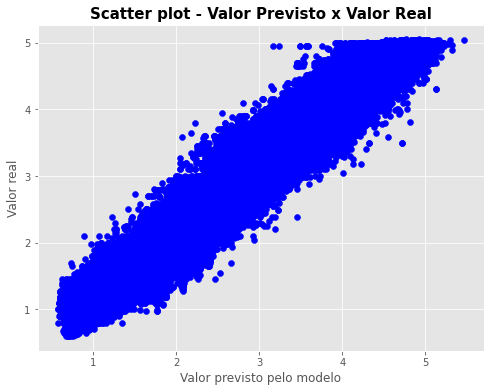

In [47]:
# definindo a área de plotagem
plt.figure(figsize=(8,6))
# definindo o gráfico
plt.scatter(modelo.predict(Xtest), ytest,  color='blue')
# inserindo os rótulos dos eixos
plt.xlabel("Valor previsto pelo modelo")
plt.ylabel("Valor real")
# inserindo o título do gráfico
plt.title("Scatter plot - Valor Previsto x Valor Real", fontweight="bold", size=15)
# mostrando o gráfico
plt.show()

### 5.2. Regressão Ridge

In [48]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Ridge())
])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,1,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=0
                      )

In [49]:
search.fit(Xtrain,ytrain)
predridge = search.predict(Xtest)

In [50]:
print('Regressão Ridge \n-------------------------------------------------------------------------')
print('MAE:',mean_absolute_error(ytest,predridge))
print('MSE:',mean_squared_error(ytest, predridge))
print('RMSE:',np.sqrt(mean_squared_error(ytest,predridge)))
print('MAE representa {}% do valor da média'.format(round(100*mean_absolute_error(ytest,predridge)/df_target_encoding_test.preco_venda.mean(),2)))

Regressão Ridge 
-------------------------------------------------------------------------
MAE: 0.09768489282804853
MSE: 0.016480086050198166
RMSE: 0.12837478743973899
MAE representa 4.13% do valor da média


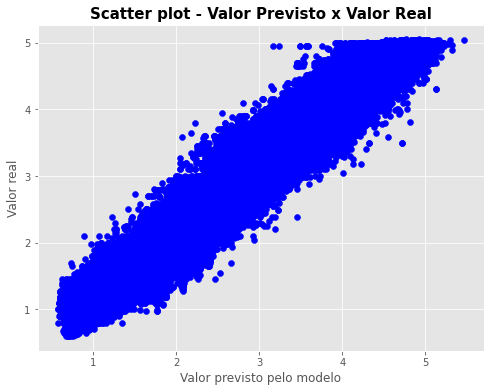

In [51]:
# definindo a área de plotagem
plt.figure(figsize=(8,6))
# definindo o gráfico
plt.scatter(predridge, ytest,  color='blue')
# inserindo os rótulos dos eixos
plt.xlabel("Valor previsto pelo modelo")
plt.ylabel("Valor real")
# inserindo o título do gráfico
plt.title("Scatter plot - Valor Previsto x Valor Real", fontweight="bold", size=15)
# mostrando o gráfico
plt.show()

### 5.3. Regressão Lasso

In [52]:
pipeline_lasso = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])
search_lasso = GridSearchCV(pipeline_lasso,
                      {'model__alpha':np.arange(0.1,1,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=0
                      )

In [53]:
search_lasso.fit(Xtrain,ytrain)
predlasso = search_lasso.predict(Xtest)

In [54]:
print('Regressão Lasso \n-------------------------------------------------------------------------')
print('MAE:',mean_absolute_error(ytest,predlasso))
print('MSE:',mean_squared_error(ytest, predlasso))
print('RMSE:',np.sqrt(mean_squared_error(ytest,predlasso)))
print('MAE representa {}% do valor da média'.format(round(100*mean_absolute_error(ytest,predlasso)/df_target_encoding_test.preco_venda.mean(),2)))

Regressão Lasso 
-------------------------------------------------------------------------
MAE: 0.13220026357310616
MSE: 0.0280638325369691
RMSE: 0.16752263290961344
MAE representa 5.59% do valor da média


## 5.4. Considerações a respeito do Modelo de Machine Learning
Para este dataset diante das condições que foram testadas tanto a Regressão Ridge quanto a Regressão Linear foram melhores que a Lasso. Verifica-se que a Regressão Linear possui um menor valor de RSME que os demais métodos, portanto, neste caso ele desempenhou melhor que os demais.

## 6. Resumo

Realizou-se uma análise exploratória dos dados de um dataset composto por informações a respeito da revenda de combustíveis no país entre os anos de 2004 e 2020, em seguida desenvolveu-se um modelo de machine learning com o objetivo de realizar predição dos preços de vendas.

Através da análise exploratória de dados foi possível obter os seguintes insights: produtos que forneceram o maior percentual de lucro em média ao longo destes anos; evolução da margem de lucro para cada um dos produtos ao longo dos anos; identificar estados que sofreram longas variações de preços de compra e preços de venda durante o período avaliado; os 10 estados com maior preço de compra e de venda de combustíveis; notar uma forte correlação entre a variável preço de compra e a variável preço de venda.

O modelo de machine learning que gerou melhores resultados utilizou a técnica de Regressão Linear. Obteve-se um valor de RMSE igual a 0,12837478741146427; além disso, nota-se que o MAE correspondeu a 4,93% da média, mostrando um baixo erro médio absoluto. 